### Scatter plot for evaluating FLC estimation performance

* data in  `FLCI_scatter_plot_data` generated in `FLCI.ipynb` and `satellite_image.ipynb`

In [1]:
import xarray as xr
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [2]:
data_dir = 'FLCI_scatter_plot_data/'
flc_est_file = 'btd_georgesbank_20240620.nc'
sat_btd_file = 'satellite_2024_06_20_06Z.nc'

flc_est = xr.open_dataset(data_dir+flc_est_file)
sat_btd = xr.open_dataset(data_dir+sat_btd_file)

In [3]:

#--- Satellite BTD data
lat2d = sat_btd['lat'].values
lon2d = sat_btd['lon'].values
lat_flat = lat2d.ravel()
lon_flat = lon2d.ravel()

#--- FLC estimation data
lat_vals = flc_est['latitude'].values
lon_vals = flc_est['longitude'].values-360

results = []
yx_pairs = np.indices(lat2d.shape).reshape(2, -1).T

#--- For each FLC estimation point, find nearest satellite data point
for lat in lat_vals.ravel():
    for lon in lon_vals.ravel(): 
        
        #--- Distance to each satellite data point
        dists = np.sqrt((lat_flat - lat)**2 + (lon_flat - lon)**2)
        min_idx = np.argmin(dists)
        y_idx, x_idx = yx_pairs[min_idx]

        #--- Extract value at the nearest point
        value = sat_btd['__xarray_dataarray_variable__'].isel(y=y_idx, x=x_idx).values.item()

        results.append({'lat': lat, 'lon': lon, 'nearest_value': value})

df_results = pd.DataFrame(results)


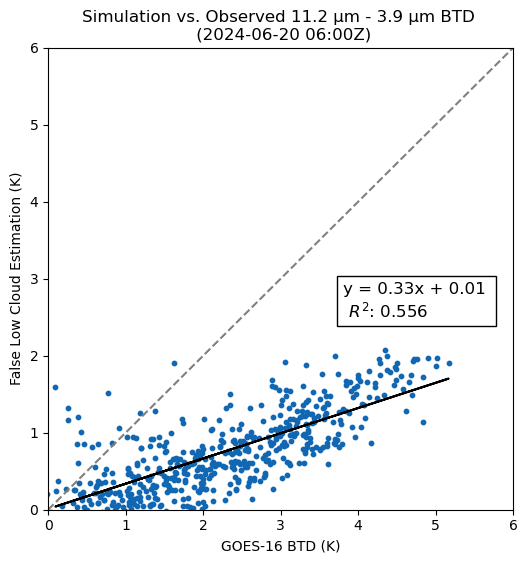

In [9]:
plt.figure(figsize=(6, 6))
low_lim = 0
high_lim = 6
plt.xlim(low_lim, high_lim)
plt.ylim(low_lim, high_lim)

#--- X is satellite BTD, y is FLC estimation
x = df_results.nearest_value
y = flc_est.BTD.values.ravel()

#--- Removing nan values (land surfaces in BTD)
mask = ~np.isnan(y)
x = x[mask]
y = y[mask]

plt.scatter(x, y, color='#1167b1', marker='o', s=10)

#--- Ideal x=y line
plt.plot([low_lim, high_lim], [low_lim, high_lim], color='grey', linestyle='--')

#--- Best fit line
mask = (x >= low_lim) & (x <= high_lim) & (y >= low_lim) & (y <= high_lim)
x_filtered = x[mask]
y_filtered = y[mask]
slope, intercept = np.polyfit(x_filtered, y_filtered, 1)
y_fit = slope * x_filtered + intercept
#------ R² calculation
ss_res = np.sum((y_filtered - y_fit) ** 2)              # Residual sum of squares
ss_tot = np.sum((y_filtered - np.mean(y_filtered)) ** 2)         # Total sum of squares
r_squared = 1 - (ss_res / ss_tot)              # R² formula
plt.plot(x_filtered, y_fit, color='black')

# Display R²
plt.text(3.8, 2.5, 
         f'y = {slope:.2f}x + {intercept:.2f} \n $R^2$: {r_squared:.3f}', 
         fontsize=12, 
         bbox=dict(facecolor='white', edgecolor='black'))

plt.title("Simulation vs. Observed 11.2 μm - 3.9 μm BTD \n (2024-06-20 06:00Z)")
plt.xlabel("GOES-16 BTD (K)")
plt.ylabel("False Low Cloud Estimation (K)")

plt.savefig(data_dir+'/scatter_plot.png', dpi=300)
plt.show()